In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import numpy as np
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
import cv2
import timeit
from os import path, makedirs, listdir
import sys
sys.setrecursionlimit(10000)
from multiprocessing import Pool
from skimage.morphology import square, dilation, watershed, erosion
from skimage import io
from shapely.wkt import loads

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [6]:
train_png = './wdata/train_png'
train_png2 = './wdata/train_png_5_3_0'
train_png3 = './wdata/train_png_pan_6_7'

masks_dir = './wdata/masks'

models_folder = './wdata/weights'
# val_output_folder = 'res34_9ch_val_0'

speed_bins = [15, 18.75, 20, 25, 30, 35, 45, 55, 65]

cities = [('AOI_7_Moscow', '/fs/scratch/PCON0003/osu10670/SN5_roads/AOI_7_Moscow_train', 'train_AOI_7_Moscow_geojson_roads_speed_wkt_weighted_simp.csv'), ('AOI_8_Mumbai', '/fs/scratch/PCON0003/osu10670/SN5_roads/AOI_8_Mumbai_train', 'train_AOI_8_Mumbai_geojson_roads_speed_wkt_weighted_simp.csv')]
          
cities_idxs = {}
for i in range(len(cities)):
    cities_idxs[cities[i][0]] = i


input_shape = (704, 704) # (384, 384)

train_files = []
for f in listdir(train_png):
    if '.png' in f:
        train_files.append(f)


train_idxs0, test_idxs = train_test_split(np.arange(len(train_files)), test_size=0.1, random_state=8)
train_idxs0, val_idxs = train_test_split(np.arange(len(train_idxs0)), test_size=0.1, random_state=601)




In [8]:
len(train_files), len(train_idxs0)

(2369, 1918)

In [4]:
os.listdir('./wdata/AOI_10_Dar_Es_Salaam/test_png')

['0__AOI_10_Dar_Es_Salaam_COG__9100__31200__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__37700__31200__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__31200__33800__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__37700__24700__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__1300__15600__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__18200__10400__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__27300__26000__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__23400__31200__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__15600__11700__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__3900__10400__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__36400__14300__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__24700__22100__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_Es_Salaam_COG__20800__1300__1300__1300__39000__39000.png',
 '0__AOI_10_Dar_

In [9]:
im = io.imread('./wdata/test_png_pan_6_7/SN5_roads_test_public_AOI_7_Moscow_chip46.png')
im.shape

(1300, 1300, 3)

In [8]:
im = io.imread('./wdata/AOI_10_Dar_Es_Salaam/test_png_pan_6_7/0__AOI_10_Dar_Es_Salaam_COG__9100__31200__1300__1300__39000__39000.png')

im.shape

FileNotFoundError: No such file: '/users/PCON0003/osu10670/SN5_roads/cannab/wdata/AOI_10_Dar_Es_Salaam/test_png_pan_6_7/0__AOI_10_Dar_Es_Salaam_COG__9100__31200__1300__1300__39000__39000.png'

In [2]:
cities = []
arg = '../AOI_7_Moscow_train'
# for i in range(1, len(arg)):
d = arg
print(d)
city = d.split('//')[-1].split('AOI_')[1].split('_')
city = 'AOI_' + city[0] + '_' + city[1]

csv_file = None
for f in listdir(d):
    if f.endswith('_simp.csv'):
        csv_file = f
        break
print(city)
cities.append((city, d, csv_file))

cities_idxs = {}
for i in range(len(cities)):
    cities_idxs[cities[i][0]] = i

../AOI_7_Moscow_train
AOI_7_Moscow


In [3]:
d.split('//')[-1].split('AOI_')[1].split('_')

['7', 'Moscow', 'train']

In [4]:
cities

[('AOI_7_Moscow',
  '../AOI_7_Moscow_train',
  'train_AOI_7_Moscow_geojson_roads_speed_wkt_weighted_simp.csv')]

In [5]:
cities_idxs

{'AOI_7_Moscow': 0}

In [6]:
dfs = []
for i in range(len(cities)):
    df = pd.read_csv(path.join(cities[i][1], cities[i][2]))
    df['speed'] = (df['length_m'] / 1609.344) / (df['travel_time_s'] / 60 / 60)
    df['speed'] = df['speed'].fillna(15).round(4)
    dfs.append(df)
    
train_png = './wdata/train_png'
train_png2 = './wdata/train_png_5_3_0'
train_png3 = './wdata/train_png_pan_6_7'

masks_dir = './wdata/masks'

speed_bins = [15, 18.75, 20, 25, 30, 35, 45, 55, 65]
# feature for speed - touch border or not
thickness = 12
radius = 16
ratio = 1

In [7]:
df = pd.read_csv(path.join(cities[i][1], cities[i][2]))
df

,ImageId,WKT_Pix,length_m,travel_time_s
0,SN5_roads_train_AOI_7_Moscow_chip0,LINESTRING (1299.994953492656 1173.11756246164...,125.659,16.062353
1,SN5_roads_train_AOI_7_Moscow_chip0,LINESTRING (795.3775061611086 1288.61614193022...,111.392,11.390940
2,SN5_roads_train_AOI_7_Moscow_chip0,LINESTRING (795.3775061611086 1288.61614193022...,4.104,0.489621
3,SN5_roads_train_AOI_7_Moscow_chip0,LINESTRING (864.1025137156248 1299.99495349079...,13.961,1.665593
4,SN5_roads_train_AOI_7_Moscow_chip0,LINESTRING (1035.400917092338 1299.99495349079...,26.918,4.014257
...,...,...,...,...
33744,SN5_roads_train_AOI_7_Moscow_chip999,LINESTRING (111.6033611930907 611.745276324451...,18.574,2.769924
33745,SN5_roads_train_AOI_7_Moscow_chip999,"LINESTRING (0 688.0236991457641, 98.2338257376...",26.861,4.005756
33746,SN5_roads_train_AOI_7_Moscow_chip999,"LINESTRING (0 626.6094984337687, 111.603361193...",22.379,0.910189
33747,SN5_roads_train_AOI_7_Moscow_chip999,"LINESTRING (21.27398721687496 0, 56.4861657954...",165.558,18.517135


In [17]:
img_id = 'SN5_roads_train_AOI_7_Moscow_chip100'
img_id0 = img_id

_sep = '_img'
if '_chip' in img_id:
    _sep = '_chip'

tmp = img_id.split(_sep)
city = tmp[0].split('train_')[1]

fn = tmp[0] + '_PS-MS' + _sep + img_id.split(_sep)[1] + '.tif'

img = io.imread(path.join(cities[cities_idxs[city]][1], 'PS-MS', fn))



In [18]:
img_bgr = (np.clip(img[..., [1, 2, 4]], None, 2000) / (2000 / 255)).astype('uint8')


In [19]:
img_0_3_5 = (np.clip(img[..., [0, 3, 5]], None, 2000) / (2000 / 255)).astype('uint8')

pan = io.imread(path.join(cities[cities_idxs[city]][1], 'PAN', fn.replace('_PS-MS_', '_PAN_')))
pan = pan[..., np.newaxis]

img_pan_6_7 = np.concatenate([pan, img[..., 7:], img[..., 6:7]], axis=2)
img_pan_6_7 = (np.clip(img_pan_6_7, None, (10000, 2000, 2000)) / (np.array([10000, 2000, 2000]) / 255)).astype('uint8')


In [22]:
df = dfs[cities_idxs[city]]
    
vals = df[(df['ImageId'] == img_id0)][['WKT_Pix', 'length_m', 'travel_time_s', 'speed']].values

msk0 = np.zeros((1300, 1300), dtype='uint8')
msk1 = np.zeros((1300, 1300), dtype='uint8')
msk2 = np.zeros((1300, 1300), dtype='uint8')

msk_speed = np.zeros((1300, 1300, len(speed_bins)), dtype='uint8')
msk_speed_cont = np.zeros((1300, 1300), dtype='uint8')

d = {}


In [26]:
df[(df['ImageId'] == img_id0)]['WKT_Pix'].iloc[0]

'LINESTRING (227.487176258117 202.5337555781007, 139.7495998945087 270.9883481189609, 0 323.2815588340163)'

In [32]:
l = loads(vals[0][0])

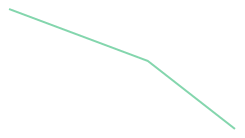

In [35]:
l

In [40]:
x,y = l.coords.xy
x_int = int(round(x[0] * 10))
y_int = int(round(y[0] * 10))
h = x_int * 100000 + y_int
h,x,y

(227502025,
 array('d', [227.487176258117, 139.7495998945087, 0.0]),
 array('d', [202.5337555781007, 270.9883481189609, 323.2815588340163]))

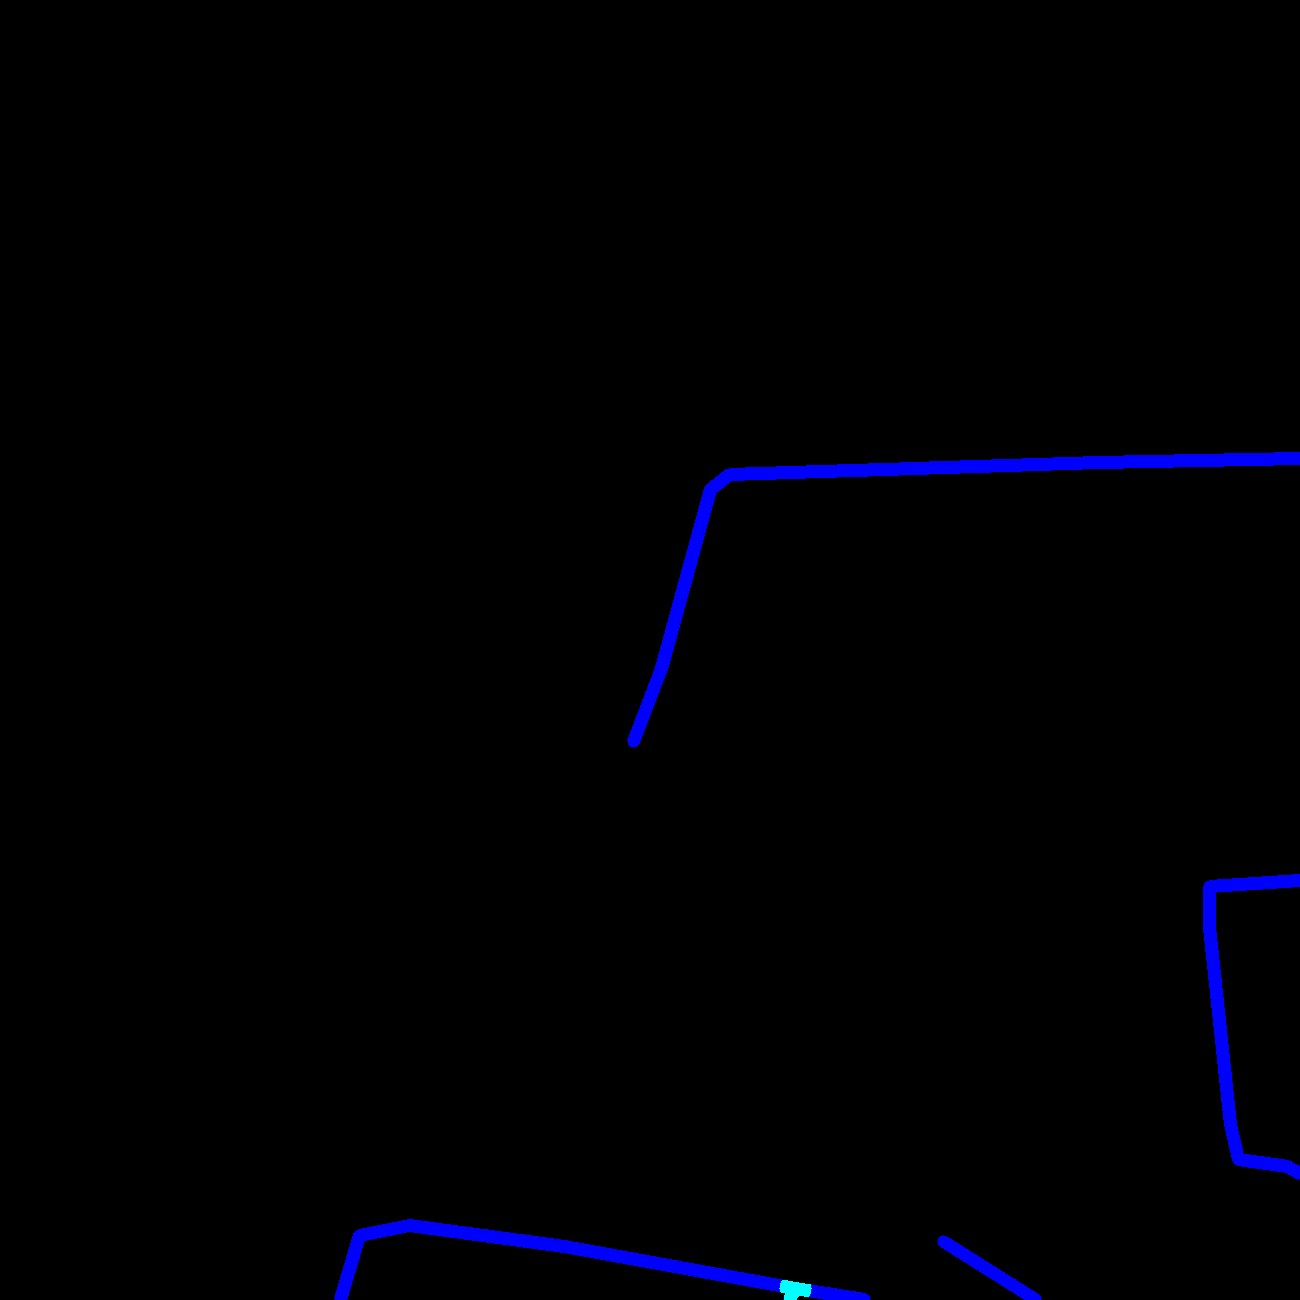

In [61]:
im



In [67]:
a = cv2.imread('./wdata/masks/SN5_roads_train_AOI_7_Moscow_chip0.png', cv2.IMREAD_COLOR)
a.shape

(1300, 1300, 3)

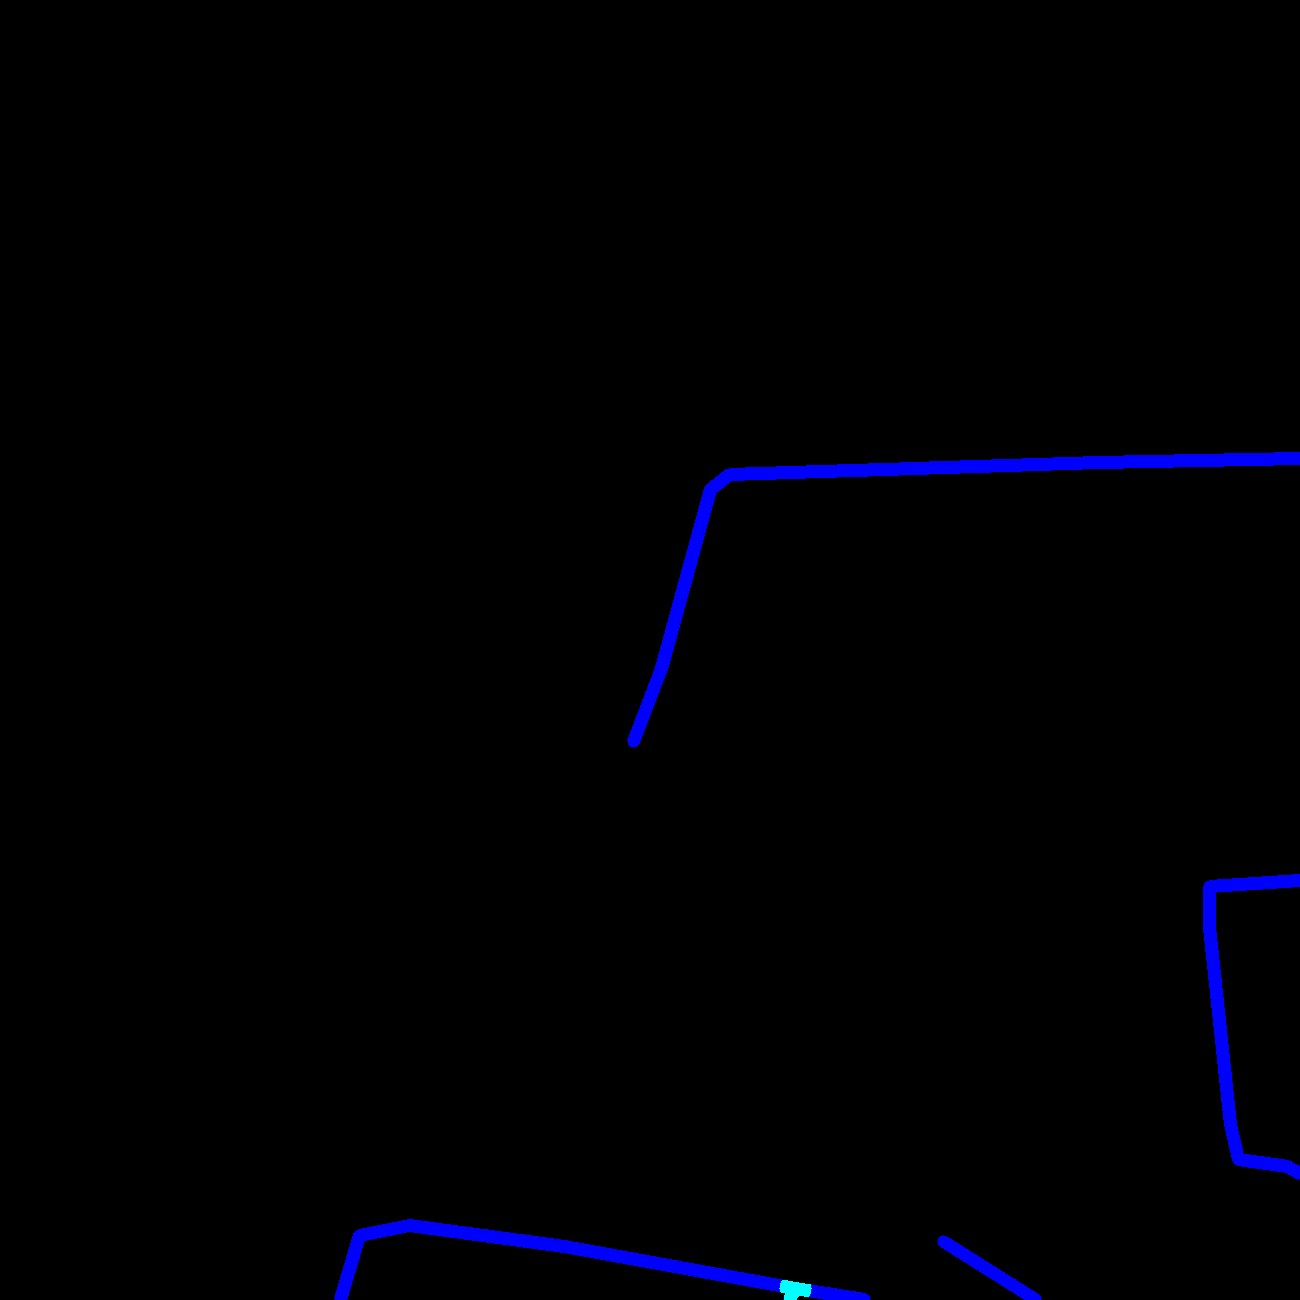

In [65]:
from PIL import Image
# im = io.imread(path.join(cities[cities_idxs[city]][1], 'PS-MS', fn))
im = Image.open('./wdata/masks/SN5_roads_train_AOI_7_Moscow_chip0.png')
# img = Image.fromarray(im)
im

In [26]:
from multiprocessing import Pool
import time
import math

N = 5000000

def cube(x):
    return math.sqrt(x)

if __name__ == "__main__":
    # first way, using multiprocessing
    start_time = time.perf_counter()
    with Pool() as pool:
      result = pool.map(cube, range(10,N))
    finish_time = time.perf_counter()
    print("Program finished in {} seconds - using multiprocessing".format(finish_time-start_time))
    print("---")
    # second way, serial computation
    start_time = time.perf_counter()
    result = []
    for x in range(10,N):
      result.append(cube(x))
    finish_time = time.perf_counter()
    print("Program finished in {} seconds".format(finish_time-start_time))

Program finished in 1.2964133709901944 seconds - using multiprocessing
---
Program finished in 1.234609733975958 seconds


In [25]:
t0 = timeit.default_timer()
if __name__ == "__main__":
    result = list(map(cube,range(10,N)))
    elapsed = timeit.default_timer() - t0
    print('Time: {:.3f} min'.format(elapsed / 60))

Time: 0.014 min


In [68]:
import torch
use_cuda = torch.cuda.is_available()

/users/PCON0003/osu10670/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
use_cuda

True

In [70]:
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: Tesla V100-PCIE-16GB
__CUDA Device Total Memory [GB]: 16.935419904


In [73]:
device = torch.device("cuda:2" if use_cuda else "cpu")

In [83]:
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [93]:
!nvidia-smi

Thu May 25 22:40:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                  Off |
| N/A   26C    P0    36W / 250W |  14144MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [81]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1,2,3,4'

In [91]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1523541962509828039]

In [92]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [87]:
tf.test.is_built_with_gpu_support()

True

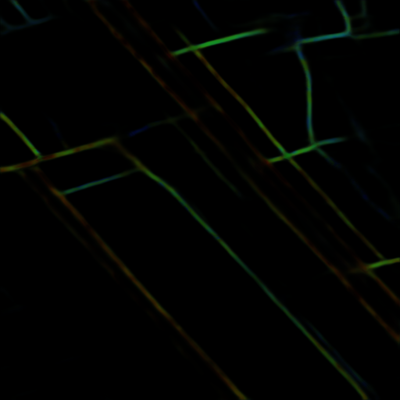

In [28]:
from PIL import Image
# im = io.imread(path.join(cities[cities_idxs[city]][1], 'PS-MS', fn))
im = Image.open('./wdata/test_pred/SN5_roads_test_public_AOI_7_Moscow_chip20_speed0.png')
# img = Image.fromarray(im)
im.resize((400,400))

In [45]:
import cv2
img = cv2.imread('./wdata/test_pred/SN5_roads_test_public_AOI_7_Moscow_chip22.png', cv2.IMREAD_COLOR)

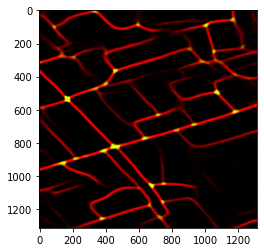

In [46]:
import matplotlib.pyplot as plt
plt.imshow(img)
